# Prophet, with less features
*Anders Poire, 30-03-2020*

Goals: make a prophet model with most possible non-correlated features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [4]:
sns.set()

## Pre-processing

We edited our pre-processing to drop features that we found to have 
high correlation.
Furthermore, we take a mean of the vegatation indices (as they are also highly correlated)

In [67]:
def get_dataset(path):
    features = pd.read_csv(path)
    features = features.drop(
        ['year', 'weekofyear'],
        axis = 1
    )
    features['ndvi_s'] = (features['ndvi_se'] + features['ndvi_sw'])/2
    features['ndvi_n'] = (features['ndvi_ne'] + features['ndvi_nw'])/2
    
    features = features.drop(
        [
            'reanalysis_sat_precip_amt_mm',
            'reanalysis_max_air_temp_k',
            'reanalysis_min_air_temp_k',
            'reanalysis_air_temp_k',
            'reanalysis_dew_point_temp_k',
            'ndvi_ne', 'ndvi_nw',
            'ndvi_se', 'ndvi_sw'
            
        ],
        axis = 1
    )
    features = features.rename({'week_start_date': 'ds'}, axis = 1)
    features_sj = features[features['city'] == 'sj'].drop('city', axis = 1)
    features_iq = features[features['city'] == 'iq'].drop('city', axis = 1)
    return (features_sj, features_iq)

In [162]:
DATA_PATH = '../data/raw'
train_sj, train_iq = get_dataset(join(DATA_PATH,
    'dengue_features_train.csv'))
test_sj, test_iq = get_dataset(join(DATA_PATH,
    'dengue_features_test.csv'))

In [13]:
train_labels = train_labels = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))

## Modeling

## San Juan

In [ ]:
train_sj

In [184]:
model_sj = Prophet(
    growth = 'linear',
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative',
    changepoint_prior_scale = 0.01
)
for name in train_sj.columns.values[1:]:
    model_sj.add_regressor(name)

Mostly the same as before. I found a bug in `sklearn` where if I have `('pass', 'passthrough', ['ds'])` after `('num', numeric_transformer, numeric_features)` in my `ColumnTransformer` then the tranformed columns will all unexplicably be shifted by 1

In [185]:
numeric_features = train_sj.columns[1:]
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy = 'median')),
    ('scale', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers =  [
        ('pass', 'passthrough', ['ds']),
        ('num', numeric_transformer, numeric_features),
    ]
)

In [186]:
train_sj_t = pd.DataFrame(preprocessor.fit_transform(train_sj), columns = train_sj.columns)
train_sj_t['y'] = train_labels[train_labels['city'] == 'sj']['total_cases']

In [187]:
model_sj.fit(train_sj_t)

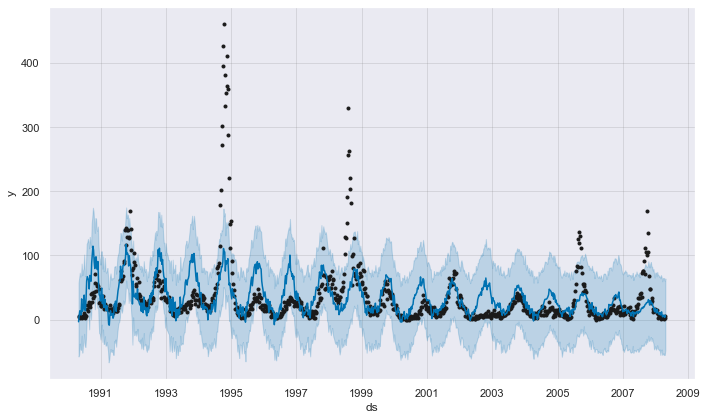

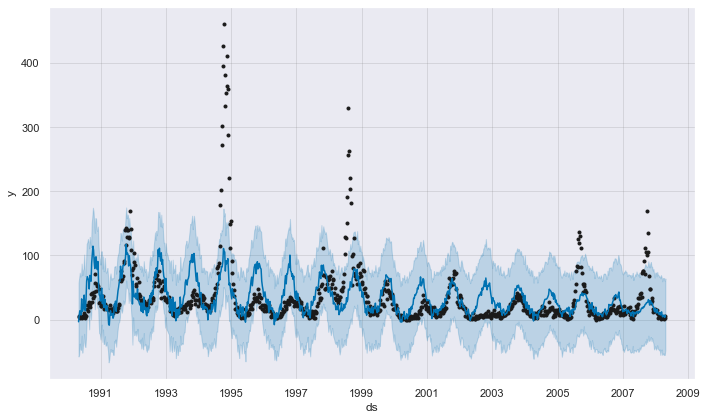

In [188]:
history = model_sj.predict(train_sj_t)
model_sj.plot(history)

In [189]:
cv_sj = cross_validation(model_sj, horizon = '365 days')

INFO:fbprophet:Making 28 forecasts with cutoffs between 1993-10-25 12:00:00 and 2007-04-23 00:00:00


In [190]:
mean_absolute_error(cv_sj['yhat'], cv_sj['y'])

41.13307318563404

Let's compare this to our training set error when fitting on all of the data

## Take-aways

It seems likely that we are overfitting. Train error is much lower than CV error for both models